## Import data and packages

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from fractions import Fraction 

In [15]:
df_all = pickle.load(open("all_scraped_recipes.pickle", "rb"))
df_all.shape

(1920, 15)

## Clean data

### Check that all columns have the correct datatype; fix as needed

In [16]:
# convert columns to floats and strings as needed
df_all[['calories','rating_count','avg_rating']] = df_all[['calories','rating_count','avg_rating']].apply(pd.to_numeric) 

df_all[['title','cook_time','author','topnote']] = df_all[['title','cook_time','author','topnote']].astype(str)



In [17]:
# translate both date columns into datetime types
df_all['upload_date'] = pd.to_datetime(df_all['upload_date'])
df_all['img_date'] = pd.to_datetime(df_all['img_date'])

# find the max of the two date columns as new column "date"
# rationale is that we want the date to represent the most recent date the recipe was promoted 
# (some older recipes are re-released)
df_all['date'] = df_all[['img_date','upload_date']].max(axis=1)

### Normalize all recipe cook times to total minutes

In [18]:
from nytc_cleaner import extract_hours,extract_minutes

In [19]:
# Using the minute and hour extraction functions, create final time column called "total_time_min"
df_all['minutes'] = df_all['cook_time'].apply(extract_minutes)
df_all['hours'] = df_all['cook_time'].apply(extract_hours)
df_all['total_time_min'] = df_all['minutes'] + df_all['hours']*60

### Check for missing/erroneous data and drop as needed

In [20]:
# check which variables are missing data
df_all.isnull().sum()

title                 0
img_date              0
upload_date        1797
features            587
calories            696
cook_time             0
recipe_steps         36
num_steps            36
author                0
ingredients           0
num_ingredients       0
tags                  0
topnote               0
rating_count          5
avg_rating            5
date                  0
minutes               0
hours                 0
total_time_min        0
dtype: int64

We're missing some data in the following categories:
- **upload date:** expected and not an issue; this should only have a value if the recipe was updated and reposted, otherwise we'll use the "img_date" field for most recipes
- **features:** expected and not an issue; I know that not every recipe gets a feature. This will likely become a binary feature
- **calories:** expected and presents a problem. I knew that not *every* recipe has nutritional information yet, but it seems like only 36% of my scraped recipes have this information. If I want to use it, I'll have to limit my dataset or try to impute the missing values
- **recipe steps and num steps:** unexpected, but not a major issue since it's only two percent of my data. I'll just drop these rows entirely.
- **rating count and avg rating:** unexpected, but not a major issue since it's only 0.2 percent of my data. I'll just drop these rows entirely.

In [21]:
# drop all rows where identified columns are NaN
df = df_all.dropna(subset=['recipe_steps','num_steps','rating_count','avg_rating'])

In [22]:
# drop all rows where total cook time is 0
mask = df['total_time_min'] == 0
df = df[~mask]
df.shape

(1852, 19)

## Exploratory Data Analysis

### determine reasonable date range
We don't want to penalize more recent recipes that may not have had time yet to accumulate ratings, nor do we want to penalize old recipes released before Cooking usership grew.

In [23]:
# mean ratings count by quarter
quarterly = df.groupby(pd.Grouper(key='date', freq='Q')).agg({'rating_count':['count','mean', 'sem']}).round(0).reset_index()
quarterly

date rating_count               
                     count    mean    sem
0  2008-09-30            1   102.0    NaN
1  2008-12-31            0     NaN    NaN
2  2009-03-31            0     NaN    NaN
3  2009-06-30            4   107.0   26.0
4  2009-09-30            0     NaN    NaN
5  2009-12-31            0     NaN    NaN
6  2010-03-31            0     NaN    NaN
7  2010-06-30            1   156.0    NaN
8  2010-09-30            0     NaN    NaN
9  2010-12-31            0     NaN    NaN
10 2011-03-31            0     NaN    NaN
11 2011-06-30            0     NaN    NaN
12 2011-09-30            1   405.0    NaN
13 2011-12-31            1   327.0    NaN
14 2012-03-31            1   312.0    NaN
15 2012-06-30            0     NaN    NaN
16 2012-09-30            0     NaN    NaN
17 2012-12-31            0     NaN    NaN
18 2013-03-31            0     NaN    NaN
19 2013-06-30            0     NaN    NaN
20 2013-09-30            0     NaN    NaN
21 2013-12-31           14   179.0   54.0
22 2014-03-31          108   457.0   75.0
23 2014-06-30           76   295.0   48.0
24 2014-09-30           93   257.0   68.0
25 2014-12-31          120   334.0   41.0
26 2015-03-31           81   388.0   55.0
27 2015-06-30           55   602.0  135.0
28 2015-09-30           37   488.0   78.0
29 2015-12-31           23   468.0   99.0
30 2016-03-31           17   605.0  155.0
31 2016-06-30           15  1108.0  609.0
32 2016-09-30           18   578.0  136.0
33 2016-12-31           27   305.0   99.0
34 2017-03-31           54   666.0   97.0
35 2017-06-30           42   449.0   65.0
36 2017-09-30           44   767.0  226.0
37 2017-12-31           36   363.0   88.0
38 2018-03-31           42   644.0  170.0
39 2018-06-30           34   623.0  138.0
40 2018-09-30           95   607.0   90.0
41 2018-12-31          107   922.0  154.0
42 2019-03-31          121   753.0   67.0
43 2019-06-30           91   589.0   64.0
44 2019-09-30           84   611.0   84.0
45 2019-12-31          102   733.0   90.0
46 2020-03-31          100   783.0  112.0
47 2020-06-30           99   710.0   75.0
48 2020-09-30          104   798.0   99.0
49 2020-12-31            4  1802.0  980.0

In [24]:
# remove any observations prior to 3/31/16, when it looks like ratings counts may have trended lower
df = df[df['date'] >= '2016-03-31']

# remove any very recent observations; from mid-September 2020 or later
df = df[df['date'] <= '2020-09-15']
df.shape

(1192, 19)

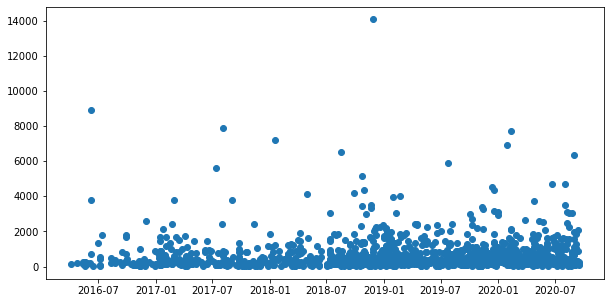

In [25]:
# chart remaining dates vs. ratings_count. No strong trend apparent, so will keep all remaining data.
plt.figure(figsize=(10,5))
plt.scatter(x=df['date'],y=df['rating_count']);


### examine and remove outliers

In [28]:
# examing 10 most popular recipes for possible outliers
df.sort_values(by='rating_count',ascending=False).head(10)

,title,img_date,upload_date,features,calories,cook_time,recipe_steps,num_steps,author,ingredients,num_ingredients,tags,topnote,rating_count,avg_rating,date,minutes,hours,total_time_min
722,Spiced Chickpea Stew With Coconut and Turmeric,2018-11-28,NaT,"[Creamy, Hearty And (Sort Of) Virtuous]",626.0,55 minutes,[Heat 1/4 cup oil in a large pot over medium. ...,6.0,Alison Roman,"[cup olive oil, plus more for serving, garlic ...",14,"[Mediterranean, Soups And Stews, Chickpea, Coc...","Spiced chickpeas are crisped in olive oil, the...",14067.0,5.0,2018-11-28,55.0,0.0,55.0
1237,Oven-Roasted Chicken Shawarma,2016-06-06,NaT,"[Chicken Shawarma Deluxe, No Rotisserie Required]",390.0,"45 minutes, plus marinating",[Prepare a marinade for the chicken. Combine t...,3.0,Sam Sifton,"[lemons, juiced, cup plus 1 tablespoon olive o...",13,"[Turkish, Chicken Thigh, Dinner, Lunch, Main C...",Here is a recipe for an oven-roasted version o...,8908.0,5.0,2016-06-06,45.0,0.0,45.0
1119,Roasted Chicken Provençal,2017-08-03,NaT,[The Enduring Appeal Of Roasted Chicken Proven...,580.0,1 hour 15 minutes,[Heat oven to 400 degrees. Season the chicken ...,4.0,Steven Stolman,"[chicken legs or 8 bone-in, skin-on chicken th...",11,"[French, Chicken, Dinner, Main Course]",This is a recipe I picked up from Steven Stolm...,7858.0,5.0,2017-08-03,15.0,1.0,75.0
1238,Shakshuka With Feta,2020-02-10,NaT,[A Rich Egg Dish That Satisfies],261.0,50 minutes,[Heat oven to 375 degrees. Heat oil in a large...,2.0,Melissa Clark,"[tablespoons extra-virgin olive oil, large oni...",14,"[Jewish, Canned Tomato, Egg, Feta, Dinner, Wee...",Shakshuka may be at the apex of eggs-for-dinne...,7711.0,5.0,2020-02-10,50.0,0.0,50.0
1774,Roberta’s Pizza Dough,2018-01-18,2014-04-08,[A Little Pizza Homework],518.0,20 minutes plus at least 3 hours' rising,"[In a large mixing bowl, combine flours and sa...",4.0,Carlo Mirarchi,"[grams 00 flour (1 cup plus 1 tablespoon), gra...",5,"[Italian, Pizza And Calzones, Dinner, Lunch, M...","This recipe, adapted from Roberta’s, the pizza...",7187.0,5.0,2018-01-18,20.0,3.0,200.0
223,Caramelized Shallot Pasta,2020-01-29,NaT,"[The Tomato Y, Shallot Y Pasta You Didn’t Know...",NaN,40 minutes,[Heat olive oil in a large heavy-bottomed Dutc...,5.0,Alison Roman,"[cup olive oil, large shallots, very thinly sl...",10,"[Pastas, Anchovy Fillet, Pasta, Shallot, Tomat...","This pasta is all about the shallots, cooked d...",6911.0,5.0,2020-01-29,40.0,0.0,40.0
1409,Roasted Salmon Glazed With Brown Sugar and Mus...,2018-08-17,NaT,NaN,212.0,15 minutes,"[Heat your oven to 400 degrees., Make a mixtur...",3.0,Sam Sifton,"[Salmon fillets, preferably wild or farmed org...",4,"[Salmon, Dinner, Easy, For One, For Two, Lunch...",This is what we call around here a no-recipe r...,6495.0,5.0,2018-08-17,15.0,0.0,15.0
1227,Mississippi Roast,2020-08-30,NaT,[The Improbable Rise Of Mississippi Roast],589.0,6 1/2 to 8 1/2 hours,[Place roast on a cutting board and rub the sa...,3.0,Robin Chapman,[boneless chuck roast or top or bottom round r...,13,"[American, Roasts, Chuck Roast, Pepperoncini, ...","An Internet darling of a recipe, a favorite of...",6338.0,4.0,2020-08-30,0.0,8.5,510.0
1287,Best Gazpacho,2019-07-25,NaT,"[Gazpacho, Seville Style, To Sip In Summer]",122.0,20 minutes plus chilling time,"[Combine tomatoes, pepper, cucumber, onion and...",4.0,Julia Moskin,"[About 2 pounds ripe red tomatoes, cored and r...",8,"[Spanish, Soups And Stews, Cucumber, Sherry Vi...","More of a drink than a soup, served in frosted...",5913.0,5.0,2019-07-25,20.0,0.0,20.0
1051,Slow-Cooker Butter Chicken,2017-07-12,NaT,[How To Feed Your Summer Crowd Without Going C...,456.0,About 5 hours,"[In medium skillet, heat oil over medium-high ...",2.0,Jennifer Steinhauer,"[tablespoons vegetable oil, medium yellow onio...",15,"[Indian, Curries, Poultry, Basmati Rice, Chick...",Not every version of butter chicken uses butte...,5636.0,4.0,2017-07-12,0.0,5.0,300.0


In [29]:
# "The Stew" famously went viral, so will remove since this model can't predict that kind of event
df = df[df['rating_count'] < 13000]
df.shape

(1191, 19)

### pairplot and variable transformations

The testing in this section resulted in two decisions:
1. Log transform the target variable, since relationships with features are slightly more linear.
2. Include the quadratic version of numerical features, since relationship with target seems slightly more linear.

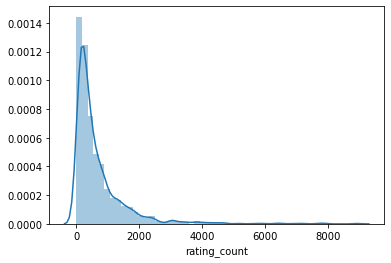

In [33]:
sns.distplot(df['rating_count']);

<ipython-input-34-5f643a005805>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_rating_count'] = np.log(df['rating_count'])


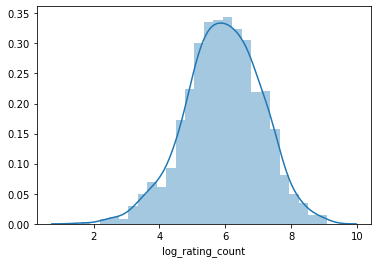

In [34]:
df['log_rating_count'] = np.log(df['rating_count'])
sns.distplot(df['log_rating_count']);

In [35]:
# create squared versions of numeric features
df['sqrd_total_time_min'] = df['total_time_min']**2
df['sqrd_num_steps'] = df['num_steps']**2
df['sqrd_num_ingredients'] = df['num_ingredients']**2

<ipython-input-35-be18bd7ee96d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sqrd_total_time_min'] = df['total_time_min']**2
<ipython-input-35-be18bd7ee96d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sqrd_num_steps'] = df['num_steps']**2
<ipython-input-35-be18bd7ee96d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [37]:
# set seaborn styles for presentation
sns.set_style('whitegrid')

my_palette = ['#29B3FF','#29B3FF','#FBC00E','#FFD774']
sns.set_palette(palette=my_palette)

col_codes = ['y','m','c','t']
c = lambda x: palette[col_codes.index(x)]


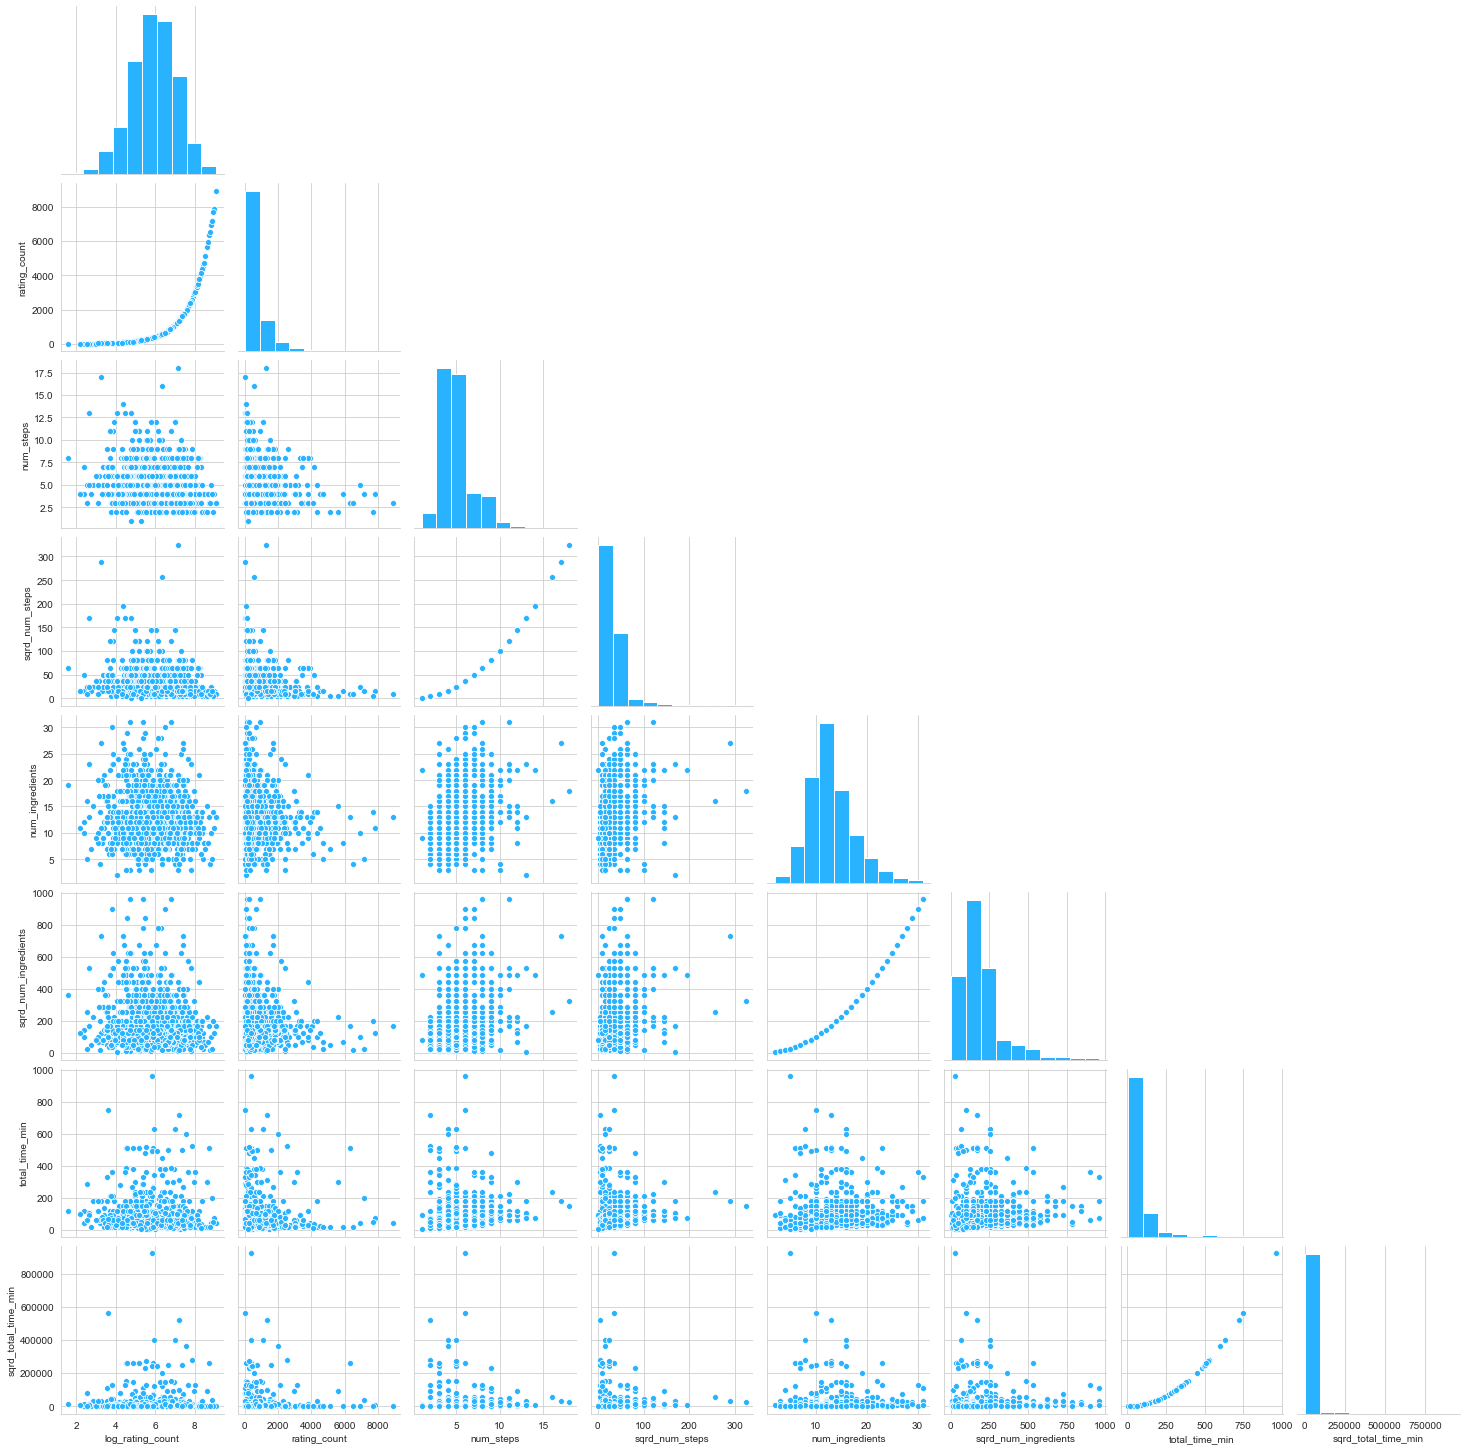

In [38]:
sns.pairplot(data=df[['log_rating_count','rating_count', 'num_steps',
                      'sqrd_num_steps','num_ingredients', 'sqrd_num_ingredients',
                      'total_time_min','sqrd_total_time_min']], corner=True);

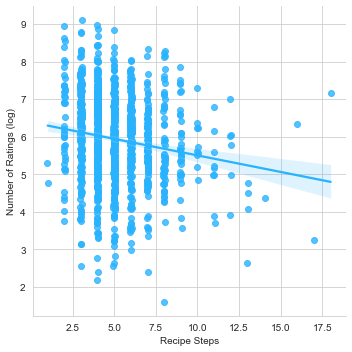

In [39]:
ax = sns.lmplot(x='num_steps',y='log_rating_count', x_jitter=.05,data=df,palette='t')
ax.set(xlabel='Recipe Steps', ylabel='Number of Ratings (log)');

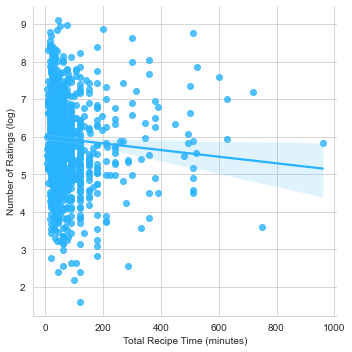

In [40]:
ax = sns.lmplot(x='total_time_min',y='log_rating_count', x_jitter=.05,data=df,palette='t')
ax.set(xlabel='Total Recipe Time (minutes)', ylabel='Number of Ratings (log)');

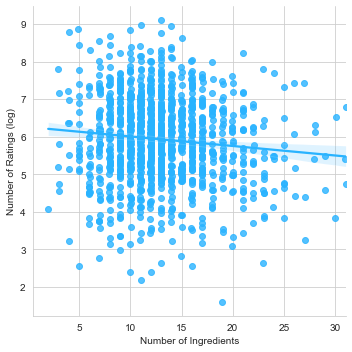

In [41]:
ax = sns.lmplot(x='num_ingredients',y='log_rating_count', x_jitter=.05,data=df,palette='t')
ax.set(xlabel='Number of Ingredients', ylabel='Number of Ratings (log)');

### Create month and weekday variables

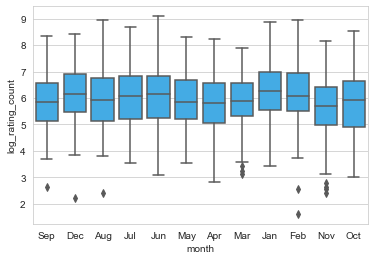

In [42]:
# create a column for month and explore relationship with target variable
df['month'] = df['date'].dt.strftime('%b')
sns.boxplot(x='month',y='log_rating_count',data=df,palette={'#29B3FF'});

In [255]:
df.groupby(by=['month']).agg({'rating_count': ['count','mean', 'sem', 'median']})

rating_count                               
             count        mean         sem median
month                                            
Apr            105  565.219048   60.914979  331.0
Aug            118  845.059322  118.356501  369.5
Dec             59  829.864407  127.766266  465.0
Feb             94  808.244681  108.140750  427.0
Jan            128  834.617188   91.828065  528.0
Jul             82  744.341463  109.379236  435.0
Jun             80  781.287500  133.922724  473.5
Mar             95  522.442105   49.225174  364.0
May             96  611.052083   70.054137  343.0
Nov            110  584.854545   74.331846  300.5
Oct            102  660.843137   87.328779  380.0
Sep            122  553.606557   57.092240  341.0

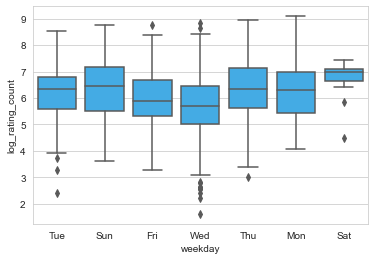

In [45]:
# create a column for weekday and explore relationship with target variable
df['weekday'] = df['date'].dt.strftime('%a')
sns.boxplot(x='weekday',y='log_rating_count',data=df,palette={'#29B3FF'});

In [44]:
df.groupby(by=['weekday']).agg({'rating_count': ['count','mean', 'sem', 'median']})

rating_count                                
               count        mean         sem  median
weekday                                             
Fri               99  666.373737   90.799616   363.0
Mon               92  913.565217  140.114053   552.5
Sat               12  999.916667  137.851669  1082.0
Sun              130  967.807692   91.382703   628.5
Thu              109  972.862385  121.832621   564.0
Tue              125  786.096000   79.109435   557.0
Wed              624  528.538462   27.685622   299.0

In [46]:
# create dummy variables for month and weekday
df = pd.get_dummies(df, columns=['weekday','month'],drop_first=True)
df.head()

,title,img_date,upload_date,features,calories,cook_time,recipe_steps,num_steps,author,ingredients,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
20,Khoresh Karafs (Persian Celery Stew With Lamb),2020-09-15,NaT,NaN,NaN,1 hour,[Trim or break off thicker parts of the parsle...,6.0,Daniela Galarza,"[large bunch curly parsley, small bunch fresh ...",...,0,0,0,0,0,0,0,0,0,1
22,Vegetarian Kofta Curry,2020-09-13,NaT,[I Think Of My Grandfather Every Time I Make K...,NaN,1 hour,"[Put the garlic, ginger and green chiles in a ...",5.0,Tejal Rao,"[garlic cloves, (2-inch) piece fresh ginger, p...",...,0,0,0,0,0,0,0,0,0,1
23,Amu’s Chicken Korma,2020-09-11,NaT,NaN,NaN,1 1/2 hours,"[Cut onion in half, trim off the root, and thi...",6.0,Sohla El-Waylly,"[large onion, peeled, plus more for serving, (...",...,0,0,0,0,0,0,0,0,0,1
24,Sheet-Pan Shrimp Boil,2020-09-15,NaT,NaN,NaN,50 minutes,[Heat oven to 425 degrees. Place a rack in the...,7.0,Millie Peartree,"[pound baby red or yellow potatoes, halved (or...",...,0,0,0,0,0,0,0,0,0,1
25,Crab and Shrimp Boil Pasta,2020-09-15,NaT,NaN,NaN,35 minutes,[Bring a large pot of salted water to boil for...,6.0,Millie Peartree,"[Kosher salt, pound smoked sausage, such as ki...",...,0,0,0,0,0,0,0,0,0,1


### Recipe 'Features'

In [47]:
# create variable indicating whether recipe got a feature or not
df['featured'] = df['features'].isna().apply(lambda x: 1 if x==0 else 0)
df[['featured','features']].head(5)

,featured,features
20,0,NaN
22,1,[I Think Of My Grandfather Every Time I Make K...
23,0,NaN
24,0,NaN
25,0,NaN


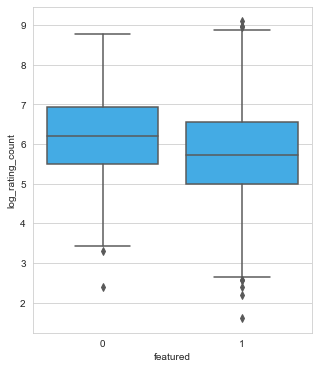

In [48]:
# relationship between this and target variable is not strong; don't think I'll include in model
fig, ax = plt.subplots(figsize=(5,6))
sns.boxplot(y=df['log_rating_count'],x=df['featured']);

### Exploration of author impact and creating dummy variables

In [49]:
# create dataframe of top 30 contributing authors only (i.e. those with ~7 or more recipes)
topauth = df['author'].value_counts().index[:30].tolist()
df_top_auth = df[df['author'].isin(topauth)]

# explore differences in popularity by author
author_summary = df_top_auth.groupby(by=['author']).agg({'rating_count': ['count','mean', 'sem', 'median']}).reset_index(
).sort_values(('rating_count', 'count'), ascending=False).round(0)
author_summary

author rating_count                       
                              count    mean    sem  median
17       Melissa Clark          161   756.0   66.0   488.0
6          David Tanis          124   339.0   34.0   225.0
1           Ali Slagle           75  1198.0  141.0   766.0
2         Alison Roman           58  1179.0  144.0   804.0
5           Colu Henry           58   852.0  103.0   586.0
14            Kay Chun           47   738.0  117.0   409.0
22    Sarah DiGregorio           46   701.0  106.0   508.0
15         Lidey Heuck           35   707.0  105.0   605.0
0         Alexa Weibel           31   707.0   95.0   642.0
21      Sarah Copeland           30   642.0   96.0   597.0
29    Yotam Ottolenghi           25   295.0   39.0   278.0
20        Samin Nosrat           21   524.0  119.0   455.0
28    Yewande Komolafe           20   548.0  157.0   418.0
19          Sam Sifton           20  1640.0  510.0   628.0
9   Gabrielle Hamilton           19   231.0   57.0   157.0
25              Sue Li           17   738.0  161.0   439.0
26       Susan Spungen           14   604.0  111.0   494.0
27           Tejal Rao           14   566.0  120.0   422.0
13        Julia Moskin           13  1946.0  480.0  1239.0
8   Florence Fabricant           12   134.0   29.0   111.0
10        Genevieve Ko           10   515.0  149.0   514.0
3      Angela Dimayuga           10   435.0  220.0   136.0
7           Dawn Perry            8   611.0  109.0   530.0
16        Mark Bittman            8   824.0  301.0   510.0
23        Sarah Jampel            8   564.0  214.0   270.0
24        Sean Sherman            7    73.0   33.0    36.0
11  J. Kenji López-Alt            7   444.0  127.0   319.0
12         Joan Nathan            6   324.0  126.0   270.0
4        Clare de Boer            5   454.0   96.0   417.0
18         Pati Jinich            5   128.0   32.0    94.0

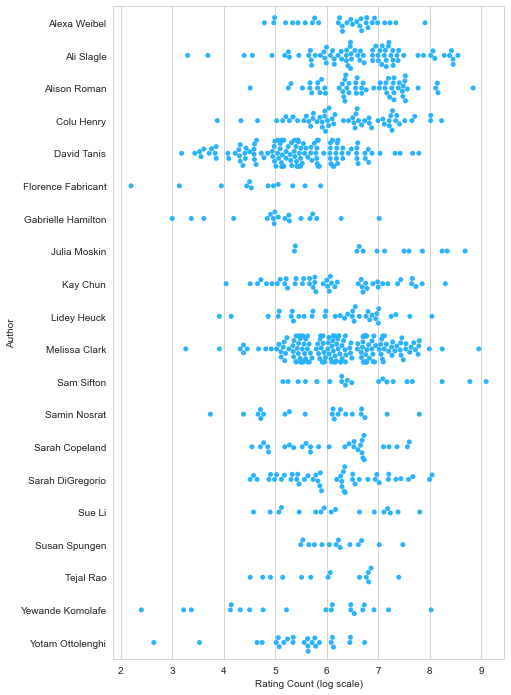

In [51]:
# swarmplot of 20 most prolific authors
boxauth = df['author'].value_counts().index[:20].tolist()
boxplot_auth = df[df['author'].isin(boxauth)]

fig, ax = plt.subplots(figsize=(7,12))
sns.swarmplot(y=boxplot_auth['author'],x=boxplot_auth['log_rating_count'],orient="h",palette={'#29B3FF'},order=sorted(boxauth))
ax.set(xlabel='Rating Count (log scale)', ylabel='Author');



In [52]:
# the top 30 authors account for ~77% of the data; we'll call the rest "other"
author_counts = df['author'].value_counts(normalize=True).cumsum()
author_counts.head(30)

Melissa Clark         0.135181
David Tanis           0.239295
Ali Slagle            0.302267
Alison Roman          0.350966
Colu Henry            0.399664
Kay Chun              0.439127
Sarah DiGregorio      0.477750
Lidey Heuck           0.507137
Alexa Weibel          0.533165
Sarah Copeland        0.558354
Yotam Ottolenghi      0.579345
Samin Nosrat          0.596977
Yewande Komolafe      0.613770
Sam Sifton            0.630563
Gabrielle Hamilton    0.646516
Sue Li                0.660789
Tejal Rao             0.672544
Susan Spungen         0.684299
Julia Moskin          0.695214
Florence Fabricant    0.705290
Angela Dimayuga       0.713686
Genevieve Ko          0.722082
Mark Bittman          0.728799
Dawn Perry            0.735516
Sarah Jampel          0.742233
Sean Sherman          0.748111
J. Kenji López-Alt    0.753988
Joan Nathan           0.759026
Pati Jinich           0.763224
Clare de Boer         0.767422
Name: author, dtype: float64

In [53]:
# create list of other authors
other_authors = list(author_counts[author_counts > 0.767].index)

# create new author column with "other authors" replaced with "other"
df['auth'] = df['author'].copy()
df['auth'] = df['auth'].replace(other_authors,'Other') 

# create dummy variables for author
df = pd.get_dummies(df, columns=['auth'])
df.head()

,title,img_date,upload_date,features,calories,cook_time,recipe_steps,num_steps,author,ingredients,...,auth_Samin Nosrat,auth_Sarah Copeland,auth_Sarah DiGregorio,auth_Sarah Jampel,auth_Sean Sherman,auth_Sue Li,auth_Susan Spungen,auth_Tejal Rao,auth_Yewande Komolafe,auth_Yotam Ottolenghi
20,Khoresh Karafs (Persian Celery Stew With Lamb),2020-09-15,NaT,NaN,NaN,1 hour,[Trim or break off thicker parts of the parsle...,6.0,Daniela Galarza,"[large bunch curly parsley, small bunch fresh ...",...,0,0,0,0,0,0,0,0,0,0
22,Vegetarian Kofta Curry,2020-09-13,NaT,[I Think Of My Grandfather Every Time I Make K...,NaN,1 hour,"[Put the garlic, ginger and green chiles in a ...",5.0,Tejal Rao,"[garlic cloves, (2-inch) piece fresh ginger, p...",...,0,0,0,0,0,0,0,1,0,0
23,Amu’s Chicken Korma,2020-09-11,NaT,NaN,NaN,1 1/2 hours,"[Cut onion in half, trim off the root, and thi...",6.0,Sohla El-Waylly,"[large onion, peeled, plus more for serving, (...",...,0,0,0,0,0,0,0,0,0,0
24,Sheet-Pan Shrimp Boil,2020-09-15,NaT,NaN,NaN,50 minutes,[Heat oven to 425 degrees. Place a rack in the...,7.0,Millie Peartree,"[pound baby red or yellow potatoes, halved (or...",...,0,0,0,0,0,0,0,0,0,0
25,Crab and Shrimp Boil Pasta,2020-09-15,NaT,NaN,NaN,35 minutes,[Bring a large pot of salted water to boil for...,6.0,Millie Peartree,"[Kosher salt, pound smoked sausage, such as ki...",...,0,0,0,0,0,0,0,0,0,0


### Exploration of recipe tags and creating dummy variables

First, just explore trends among top 50 tags in a separate dataframe

<ipython-input-57-97437f9ebdf3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tags[i] = df_tags['tags'].apply(lambda x : 1 if i in x else 0)


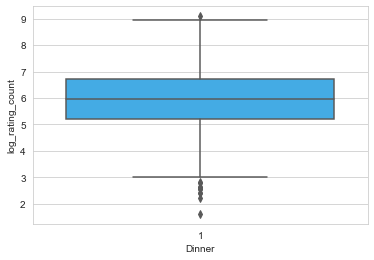

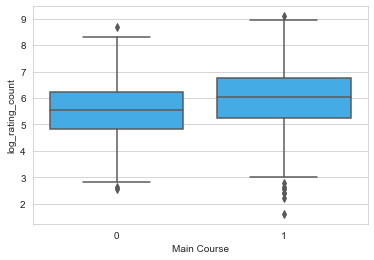

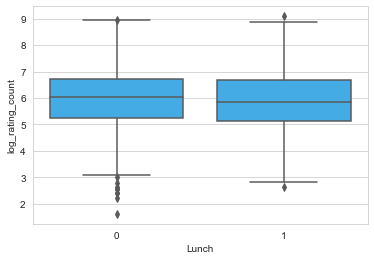

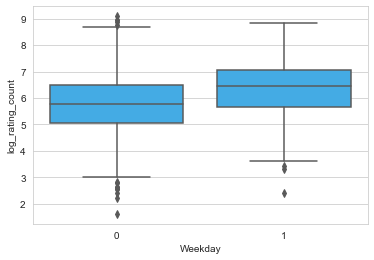

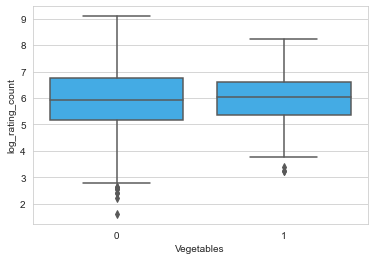

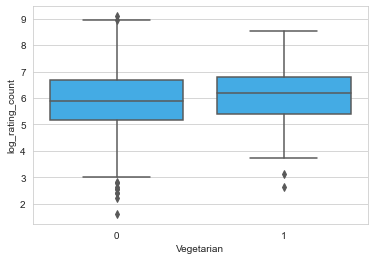

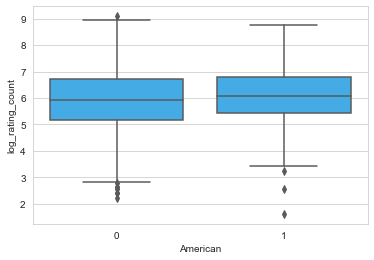

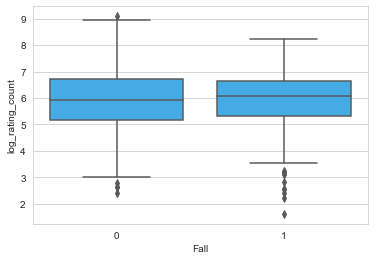

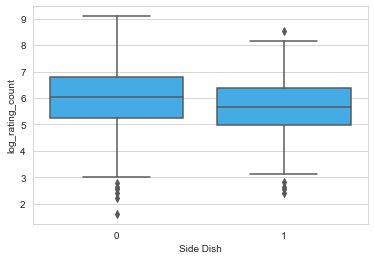

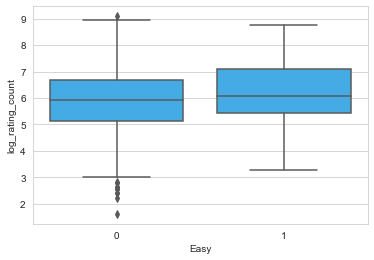

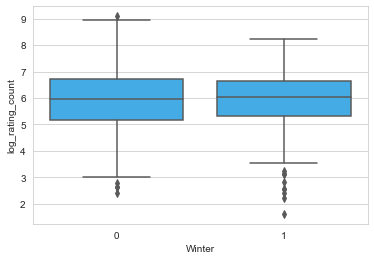

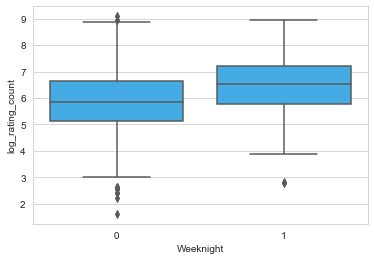

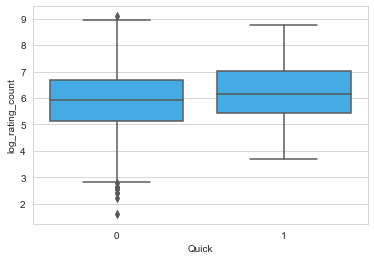

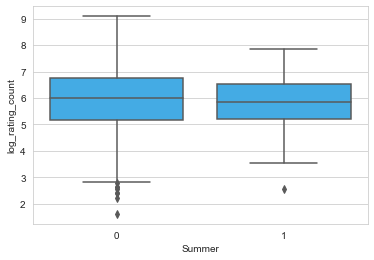

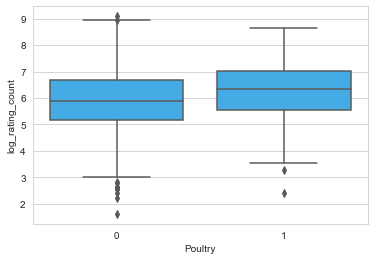

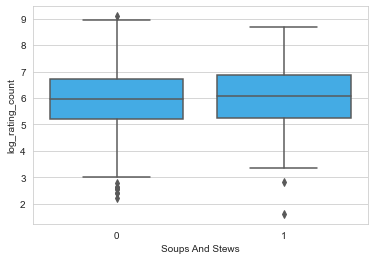

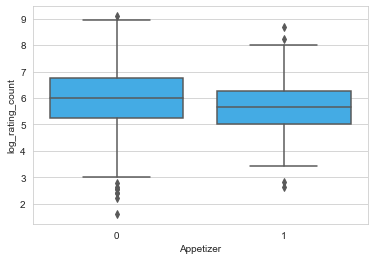

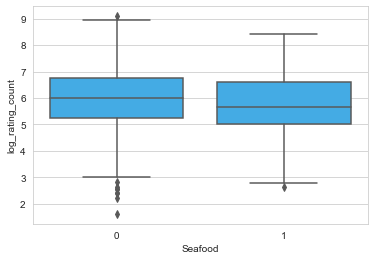

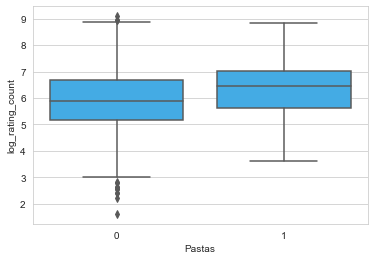

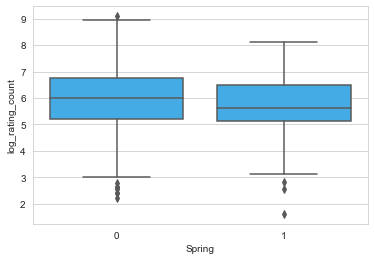

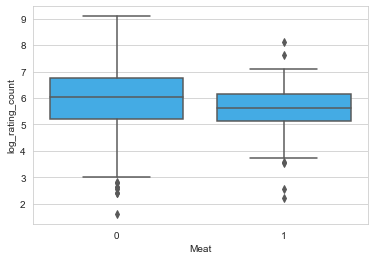

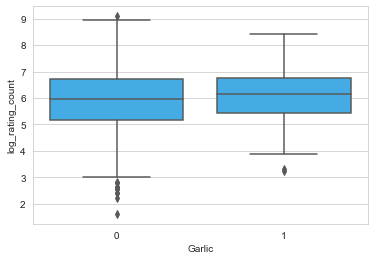

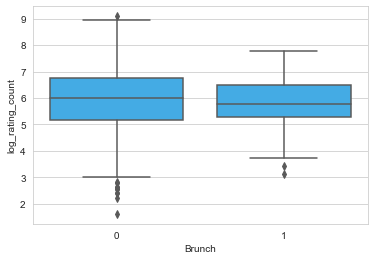

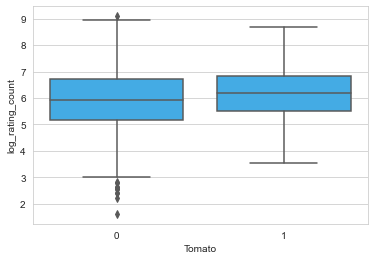

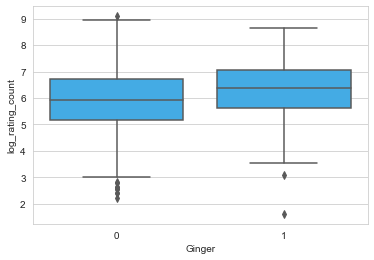

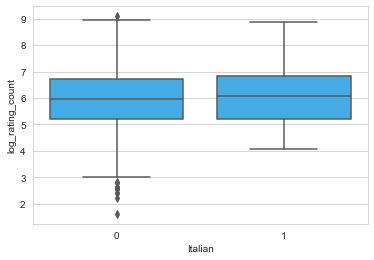

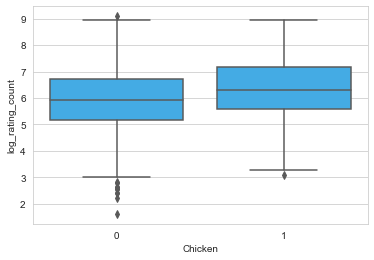

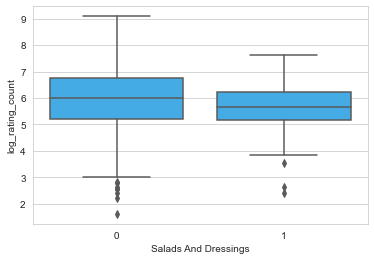

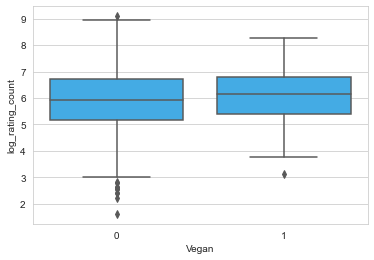

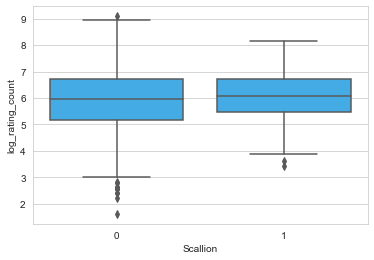

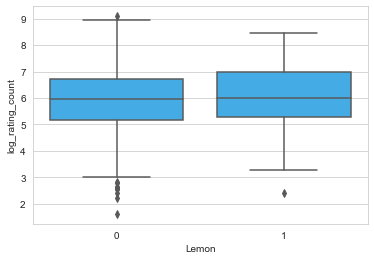

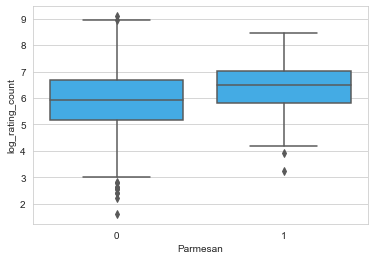

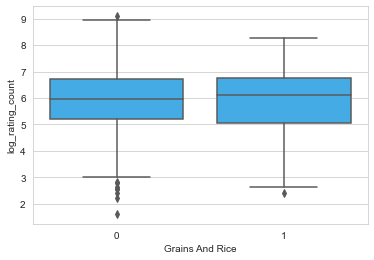

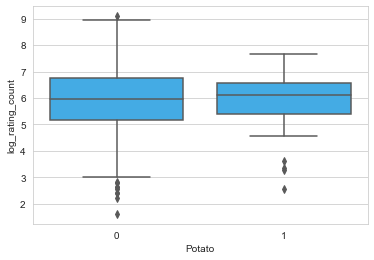

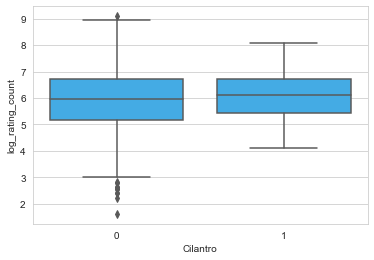

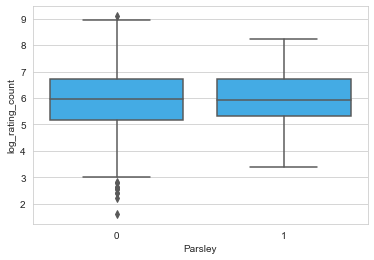

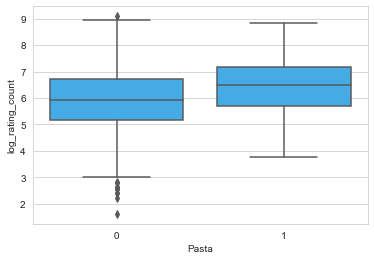

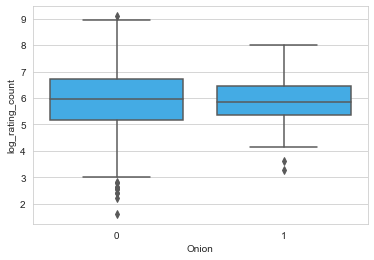

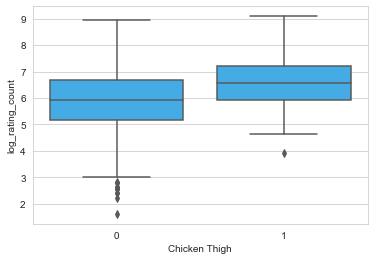

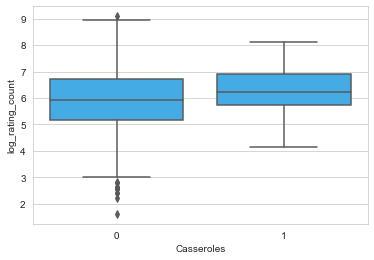

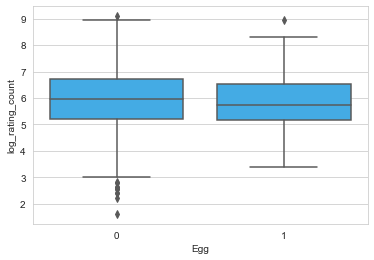

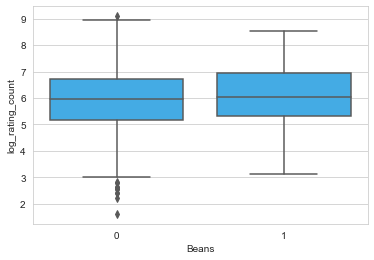

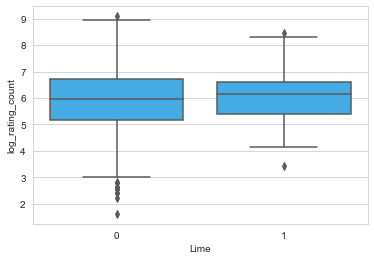

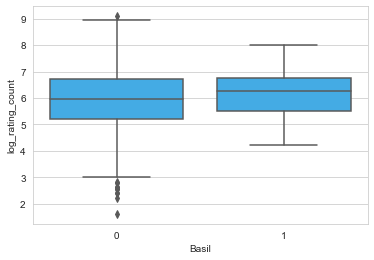

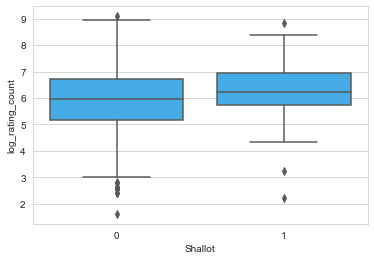

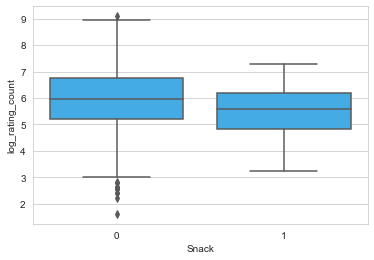

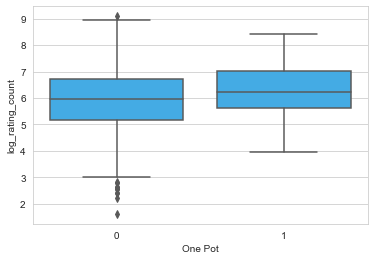

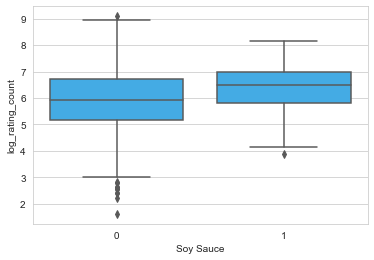

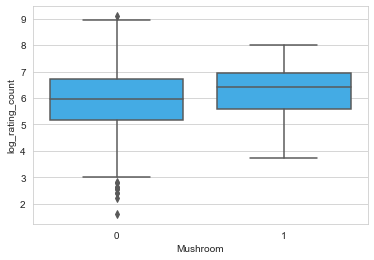

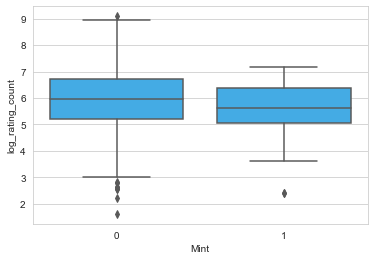

In [57]:
# create list of top 50 tags
top_50_tags = df['tags'].explode().value_counts()[:50].index.tolist()

# create new df with columns for 50 most common tags
df_tags = df[['log_rating_count','tags']]
for i in top_50_tags:
    df_tags[i] = df_tags['tags'].apply(lambda x : 1 if i in x else 0)
    
# explore relationship with target variable for each of the top 50 tags
plt.rcParams.update({'figure.max_open_warning': 0})
for t in top_50_tags:
    plt.figure()
    sns.boxplot(y=df_tags['log_rating_count'],x=df_tags[t]) 



Ultimately, I decided to just create dummy columns for the top 75 tags and will let LASSO narrow it down from there.

In [59]:
# create list of the 75 most frequent tags
top_75_tags = df['tags'].explode().value_counts()[2:75].index.tolist() #omit first two, which are "dinner" and "main course"

# create dummy columns for the 75 most frequent tags
for i in top_75_tags:
    df[i] = df['tags'].apply(lambda x : 1 if i in x else 0)

In [60]:
# now need to group similar tags based on: 
# 1) domain knowledge of whether they are similar, AND
# 2) if they have a directionally similar relationship with the target variable

# create lists of similar tags
easy = ['Weekday', 'Weeknight', 'Easy', 'Quick', 'One Pot','Casseroles']
side = ['Appetizer', 'Snack', 'Salads And Dressings', 'Side Dish']
ginger = ['Ginger']
italian = ['Italian', 'Pastas', 'Pasta','Pasta Shell']
chicken = ['Chicken',
           'Boneless Chicken Thigh',
           'Chicken Breast',
           'Chicken Cutlet',
           'Chicken Drumstick',
           'Chicken Flat',
           'Chicken Leg',
           'Chicken Thigh',
           'Chicken Wing',
           'Ground Chicken']
veg = ['Vegan', 'Vegetarian']
parm = ['Parmesan','Parmigiano Reggiano','Pecorino','Pecorino Romano','Pecorino Rossellino']
shallot = ['Shallot']

# create list of tag group lists
tag_groups = [easy, side, ginger, italian, chicken, veg]

In [62]:
# update dummy columns in dataframe to indicate 1 for observations containing ANY tag within the group
for t in tag_groups:
    pattern = '|'.join(t)
    col_title = t[0]
    pattern_results = []
    for index,row in df.iterrows():
        actual_tags_str = ",".join(row['tags'])
        if any(i in actual_tags_str for i in t): 
            pattern_results.append(1)
        else:
            pattern_results.append(0)
    df[col_title] = pattern_results


### Ingredients

In [63]:
# decided too unstructured to take on -- going to omit from model for now
df['ingredients'].explode().value_counts().head(25)

Kosher salt and black pepper                   257
Kosher salt                                    184
tablespoons olive oil                          129
tablespoons unsalted butter                    125
tablespoons extra-virgin olive oil             110
Salt and pepper                                107
teaspoon kosher salt                            86
teaspoon black pepper                           81
garlic cloves, minced                           76
teaspoon red-pepper flakes                      73
teaspoon ground cumin                           70
cup extra-virgin olive oil                      68
garlic cloves, thinly sliced                    64
teaspoons kosher salt                           59
Black pepper                                    53
garlic cloves, finely chopped                   51
cup dry white wine                              50
large eggs                                      49
Kosher salt and freshly ground black pepper     46
teaspoon ground turmeric       

### Exploration of feature interaction
Ultimately did not include any of these in the model

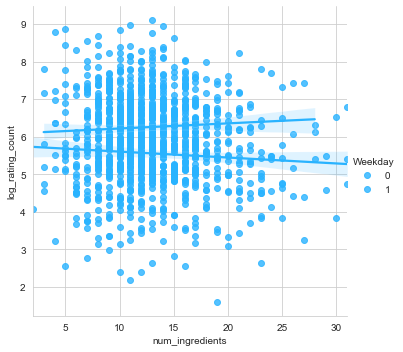

In [64]:
sns.lmplot(x='num_ingredients',y='log_rating_count',data=df,hue='Weekday')
df['num_ingredients_Easy'] = df['num_ingredients']*df['Easy']

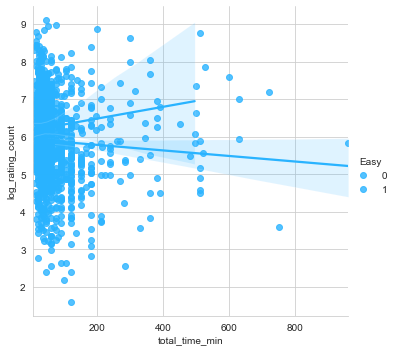

In [65]:
sns.lmplot(x='total_time_min',y='log_rating_count',data=df,hue='Easy')

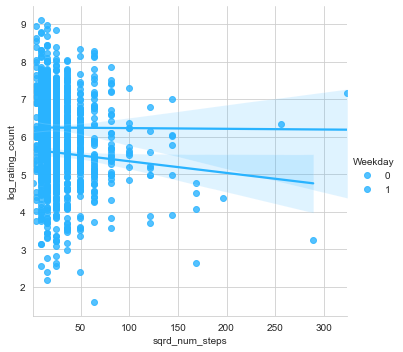

In [66]:
sns.lmplot(x='sqrd_num_steps',y='log_rating_count',data=df,hue='Weekday')

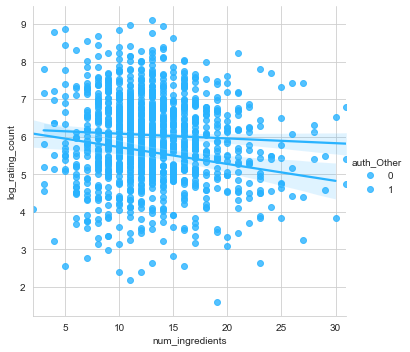

In [67]:
sns.lmplot(x='num_ingredients',y='log_rating_count',data=df,hue='auth_Other')

## Modeling

### Preprocessing: scaling and splitting

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from nytc_modeling import lr_cv_results, lasso_cv_results, ridge_cv_results

In [69]:
# identify features
# include all authors, all tags (except those that are part of a group), all numerical vars
lassocv_features_list = ['num_steps', 'sqrd_num_steps', 'num_ingredients', 'sqrd_num_ingredients',
                         'total_time_min',
                         'sqrd_total_time_min',  'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
                         'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan',
                         'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep',
                         'featured', 'auth_Alexa Weibel', 'auth_Ali Slagle', 'auth_Alison Roman', 'auth_Angela Dimayuga',
                         'auth_Colu Henry', 'auth_David Tanis', 'auth_Dawn Perry',
                         'auth_Florence Fabricant', 'auth_Gabrielle Hamilton', 'auth_Genevieve Ko',
                         'auth_J. Kenji López-Alt', 'auth_Joan Nathan', 'auth_Julia Moskin', 'auth_Kay Chun',
                         'auth_Lidey Heuck', 'auth_Mark Bittman', 'auth_Melissa Clark', 'auth_Other', 'auth_Sam Sifton',
                         'auth_Samin Nosrat', 'auth_Sarah Copeland', 'auth_Sarah DiGregorio', 'auth_Sarah Jampel',
                         'auth_Sean Sherman', 'auth_Sue Li', 'auth_Susan Spungen', 'auth_Tejal Rao',
                         'auth_Yewande Komolafe', 'auth_Yotam Ottolenghi', 'Lunch', 'Weekday', 'Vegetables',
                         'American', 'Fall', 'Winter',
                         'Summer', 'Poultry', 'Soups And Stews', 'Seafood', 'Spring', 'Meat',
                         'Garlic', 'Brunch', 'Tomato', 'Ginger', 'Italian', 'Chicken', 'Vegan',
                         'Scallion', 'Lemon', 'Parmesan', 'Grains And Rice', 'Potato', 'Cilantro', 'Parsley',
                         'Onion', 'Egg', 'Beans', 'Lime', 'Basil', 'Shallot',
                         'Soy Sauce', 'Mint', 'Mushroom', 'For Two', 'Finger Foods', 'Thyme', 'French',
                         'White Wine', 'Noodles', 'Carrot', 'Indian', 'Bacon', 'Leek', 'Shrimp',
                         'Cumin', 'Feta', 'Fennel', 'Turmeric', 'Spinach', 'Salmon',
                         'Gluten Free', 'Butter', 'Dairy Free', 'Rosemary', 'Fish Sauce',
                         ]  

len(lassocv_features_list)

110

In [70]:
# define X and y
X = df[lassocv_features_list]
y = df['log_rating_count']

# create 20% test holdout
X, X_test, y, y_test = train_test_split(
    X, y, test_size=.2, random_state=33)  # ADD stratification

# standard scale data for regularization
scaler = StandardScaler(with_mean=True)
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

### Run LassoCV with many dummy variables to reduce features

In [71]:
# fit and run LassoCV on 110 features with 3-fold cross validation
lassocv_model = LassoCV(cv=3)
lassocv_model.fit(X_scaled, y)

alpha = lassocv_model.alpha_

In [73]:
# print out coefficients from lasso
coef_table = pd.DataFrame(list(zip(lassocv_features_list, lassocv_model.coef_)),columns=['feature','coefficient'])
coef_table['abs_coefficient'] = abs(coef_table['coefficient'])
coef_table = coef_table.sort_values(by='abs_coefficient', ascending=False)
coef_table.reset_index(inplace=True)
coef_table.head(40)

,index,feature,coefficient,abs_coefficient
0,70,Chicken,0.195005,0.195005
1,54,Weekday,0.189812,0.189812
2,11,weekday_Wed,-0.149631,0.149631
3,26,auth_Alison Roman,0.134298,0.134298
4,40,auth_Melissa Clark,0.094915,0.094915
5,31,auth_Florence Fabricant,-0.087850,0.087850
6,36,auth_Julia Moskin,0.087371,0.087371
7,47,auth_Sean Sherman,-0.085344,0.085344
8,41,auth_Other,-0.083399,0.083399
9,25,auth_Ali Slagle,0.073909,0.073909


In [75]:
# select all non-zero coefficients for next iteration of model
features_lassocv = list(coef_table['feature'][:35])

### Model V1, with Lasso-selected features (all non-zero coefficients)

In [78]:
# Update feature sets
X1 = X[features_lassocv]
X1_test = X_test[features_lassocv]
#X1 = np.array(X1)
X1_scaled = scaler.fit_transform(X1)
X1_test_scaled = scaler.transform(X1_test)

# run linear regression, ridge, lasso, and print results
lr_cv_results(X1_scaled, y, cv=5)
ridge_cv_results(X1_scaled, y, cv=5, alpha=alpha)
lasso_cv_results(X1_scaled, y, cv=5, alpha=alpha)

LINEAR REGRESSION
Mean train r2: 0.3511151464773329
Mean test r2: 0.26989467856082183
r2 ratio:  1.3009339359694256

Mean train MSE: 0.8454581282372026
Mean test MSE: 0.9412633785576137
Mean train MSE in number of ratings: 2.3290445712796983
Mean test MSE in number of ratings: 2.5632176878473785 

RIDGE
Mean train r2: 0.35111514572019387
Mean test r2: 0.2698993821327752
r2 ratio:  1.300911261617728

Mean train MSE: -0.8454581292254512
Mean test MSE: -0.9412578124871894
Mean train MSE in number of ratings: 0.429360610502314
Mean test MSE in number of ratings: 0.39013680766448355 

LASSO
Mean train r2: 0.31612083268393487
Mean test r2: 0.24045860009414963
r2 ratio:  1.3146580432563457

Mean train MSE: -0.8910488313526743
Mean test MSE: -0.9811465753960308
Mean train MSE in number of ratings: 0.4102252699151136
Mean test MSE in number of ratings: 0.37488102298391934 



### Model V2, fewer features to reduce overfitting

In [79]:
# iterate through various numbers of features to find best balance of metrics and overfit
for i in range(10,20,1):
    x = i
    xfeatures_lassocv = list(coef_table['feature'][:x])
    X2 = X[xfeatures_lassocv]
    X2_test = X_test[xfeatures_lassocv]
    X2 = np.array(X2)
    X2_scaled = scaler.fit_transform(X2)
    X2_test_scaled = scaler.transform(X2_test)
    print("Number of features: ",x)
    lr_cv_results(X2_scaled, y, cv=5)

Number of features:  10
LINEAR REGRESSION
Mean train r2: 0.26173081806349235
Mean test r2: 0.2361979616641416
r2 ratio:  1.1080993934895038

Mean train MSE: 0.9619393915065964
Mean test MSE: 0.9842752125909863
Mean train MSE in number of ratings: 2.616766490166058
Mean test MSE in number of ratings: 2.6758717432633876 

Number of features:  11
LINEAR REGRESSION
Mean train r2: 0.26988645476657513
Mean test r2: 0.24233699182157858
r2 ratio:  1.1136824499549782

Mean train MSE: 0.951291177194971
Mean test MSE: 0.9759517828384083
Mean train MSE in number of ratings: 2.589050424956849
Mean test MSE in number of ratings: 2.653691747650529 

Number of features:  12
LINEAR REGRESSION
Mean train r2: 0.27728585261797123
Mean test r2: 0.24771150617881582
r2 ratio:  1.1193902814421812

Mean train MSE: 0.9416377283942905
Mean test MSE: 0.9689157823454899
Mean train MSE in number of ratings: 2.564177407594449
Mean test MSE in number of ratings: 2.635085903328185 

Number of features:  13
LINEAR REGR

In [83]:
x = 20 # number of features to include in model, sorted by magnitude from LassoCV
xfeatures_lassocv = list(coef_table['feature'][:x])

# Update feature sets
X2 = X[xfeatures_lassocv]
X2_test = X_test[xfeatures_lassocv]
X2 = np.array(X2)
X2_scaled = scaler.fit_transform(X2)
X2_test_scaled = scaler.transform(X2_test)

# run linear regression, ridge, lasso, and print results
lr_cv_results(X2_scaled, y, cv=5)
ridge_cv_results(X2_scaled, y, cv=5)
lasso_cv_results(X2_scaled, y, cv=5)


# linear regression with 20 features seems to yield the best results.

LINEAR REGRESSION
Mean train r2: 0.3163945127997499
Mean test r2: 0.2681911745981252
r2 ratio:  1.179734990436787

Mean train MSE: 0.8907024592877105
Mean test MSE: 0.9430275829317303
Mean train MSE in number of ratings: 2.4368408316771153
Mean test MSE in number of ratings: 2.56774371895212 

RIDGE
Mean train r2: 0.3163945124732594
Mean test r2: 0.26819301812013496
r2 ratio:  1.179726879882954

Mean train MSE: -0.8907024597139614
Mean test MSE: -0.9430255831845132
Mean train MSE in number of ratings: 0.41036738492497915
Mean test MSE in number of ratings: 0.38944774448024394 

LASSO
Mean train r2: 0.305215060185217
Mean test r2: 0.25558396089533264
r2 ratio:  1.1941870652447137

Mean train MSE: -0.9052679260531045
Mean test MSE: -0.9607766609748275
Mean train MSE in number of ratings: 0.4044335123110232
Mean test MSE in number of ratings: 0.38259562346407433 



In [80]:
# print final selected features
print(xfeatures_lassocv)

['Chicken', 'Weekday', 'weekday_Wed', 'auth_Alison Roman', 'auth_Melissa Clark', 'auth_Florence Fabricant', 'auth_Julia Moskin', 'auth_Sean Sherman', 'auth_Other', 'auth_Ali Slagle', 'auth_Gabrielle Hamilton', 'Vegan', 'auth_David Tanis', 'weekday_Sun', 'sqrd_num_steps', 'Bacon', 'month_Nov', 'Spring', 'Salmon']


## Final Test and results

In [84]:
# Fit final model and run on holdout test data
lm = LinearRegression()
lm.fit(X2_scaled,y) 
lm.score(X2_test_scaled,y_test)

0.28127306929837337

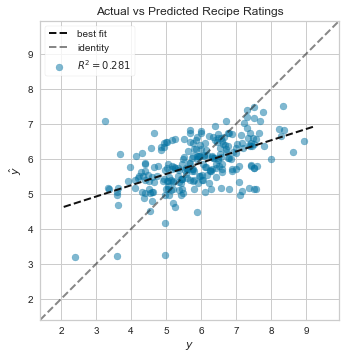

In [86]:
# plot predicted vs actual target values
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
model = LinearRegression()
visualizer = PredictionError(model, title="Actual vs Predicted Recipe Ratings",alpha=0.5,colormap={"#29B3FF"})

visualizer.fit(X2_scaled, y)  # Fit the training data to the visualizer
visualizer.score(X2_test_scaled,y_test)  # Evaluate the model on the test data
visualizer.ax.set_xlabel("Actual (log transformed)")
visualizer.show(); 

In [87]:
# generate y predictions
y_pred = lm.predict(X2_test_scaled)

# exponentiate predicted and actual ys to turn back to rating count
predicted_rating_count = np.exp(y_pred)
actual_ratings_count = np.exp(y_test)

# calculate acual mean squared error
#mse = mean_squared_error(y_true=actual_ratings_count, y_pred=predicted_rating_count)
mse = np.square(np.subtract(actual_ratings_count,predicted_rating_count)).mean()
np.sqrt(mse)

856.1318897163147

In [88]:
# calculate mean absolute error
mean_absolute_error(y_true=actual_ratings_count,y_pred=predicted_rating_count)

421.6334206335324

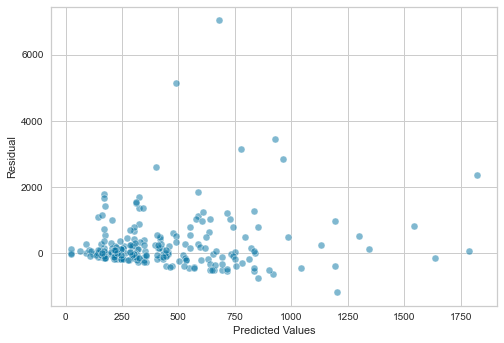

In [89]:
# calculate residuals
y_res = np.subtract(actual_ratings_count,predicted_rating_count)

# plot residuals
ax = sns.scatterplot(x=predicted_rating_count,y=y_res,palette='blue',alpha=.5)
ax.set(ylabel='Residual', xlabel='Predicted Values');

In [91]:
# print the final (scaled) coefficients
final_coefs = list(zip(lm.coef_, xfeatures_lassocv))
final_coefs

[(0.2527106311624629, 'Chicken'),
 (0.1842747249444793, 'Weekday'),
 (-0.16429594402321254, 'weekday_Wed'),
 (0.17403481520334146, 'auth_Alison Roman'),
 (0.13313579619196114, 'auth_Melissa Clark'),
 (-0.12554320461272123, 'auth_Florence Fabricant'),
 (0.12873466920347154, 'auth_Julia Moskin'),
 (-0.11846433898233444, 'auth_Sean Sherman'),
 (-0.10241197215206609, 'auth_Other'),
 (0.10154167377307137, 'auth_Ali Slagle'),
 (-0.12355956613134965, 'auth_Gabrielle Hamilton'),
 (0.11285850151591817, 'Vegan'),
 (-0.08297328152284236, 'auth_David Tanis'),
 (0.11466585110719335, 'weekday_Sun'),
 (-0.0783319925744182, 'sqrd_num_steps'),
 (-0.0640315239928923, 'Bacon'),
 (-0.08088545879255901, 'month_Nov'),
 (-0.07566553827898598, 'Spring'),
 (0.08146706428631051, 'Salmon'),
 (0.07871466667017683, 'Italian')]